## Лабораторна 5: логістична регресія. ROC. AUC. One-hot encoding

## 1
Розглянемо дані медичної страхової фірми. спираючись на характеристика пацієнтів `Members.csv` (вік, стать) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [1]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [2]:
days2 = pd.read_csv("DaysInHospital_Y2.csv", index_col="MemberID")
m = pd.read_csv("Members.csv", index_col="MemberID")
claims = pd.read_csv("Claims_Y1.csv", index_col="MemberID")

## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [3]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [4]:
f_Charlson  = claims["CharlsonIndex"].groupby(["MemberID"]).max()
f_LengthOfStay = claims["LengthOfStay"].groupby(["MemberID"]).sum()

In [5]:
f_LengthOfStay

MemberID
210         2
3197        0
3889        3
4187        0
9063        0
           ..
99995554    0
99996214    0
99997485    0
99997895    0
99998627    2
Name: LengthOfStay, Length: 76038, dtype: int64

In [6]:
f_Charlson

MemberID
210         0
3197        0
3889        1
4187        0
9063        0
           ..
99995554    0
99996214    0
99997485    0
99997895    0
99998627    1
Name: CharlsonIndex, Length: 76038, dtype: int64

## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [7]:
data = days2
data = data.join(f_Charlson)
data = data.join(f_LengthOfStay)
age = m.drop('Sex', axis=1)
data = pd.merge(data, age, on='MemberID')


# место для кода
data.head(100)

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,,
98324177,0,0,0,0,30
33899367,1,1,0,0,80
5481382,0,1,0,0,20
69908334,0,0,0,0,60
29951458,0,0,0,0,40
...,...,...,...,...,...
14352176,1,1,1,1,70
70282602,0,0,0,0,60
9822277,0,0,0,0,50


## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [8]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Применим данную функцию к `data`:

In [9]:
data = data.dropna()

In [10]:
data['AgeAtFirstClaim'] = pd.to_numeric(data['AgeAtFirstClaim'])

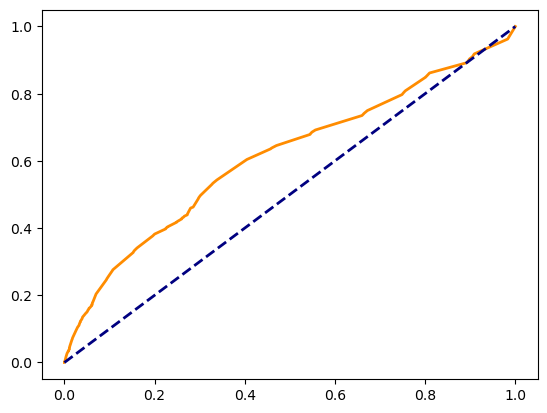

0.6125102736880302


In [11]:
calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [12]:
m = m.dropna()
sex = pd.get_dummies(m.Sex, prefix='Sex')
sex = m.join(sex,how='inner')
sex = sex.drop(['AgeAtFirstClaim','Sex'],axis=1)
data = pd.merge(data, sex, on='MemberID')
data = data.dropna()
data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex_F,Sex_M,Sex_N
MemberID,,,,,,,,
98324177,0,0,0,0,30,0,1,0
33899367,1,1,0,0,80,1,0,0
5481382,0,1,0,0,20,1,0,0
69908334,0,0,0,0,60,1,0,0
29951458,0,0,0,0,40,0,1,0
...,...,...,...,...,...,...,...,...
1702326,0,0,0,0,20,0,0,1
31530440,0,0,0,0,0,0,1,0
87102780,0,0,0,0,40,1,0,0


## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

Построившему матрицу объектов признаков, для которой логистическая регрессия работает с наилучшим качеством: +5 бонусных баллов.

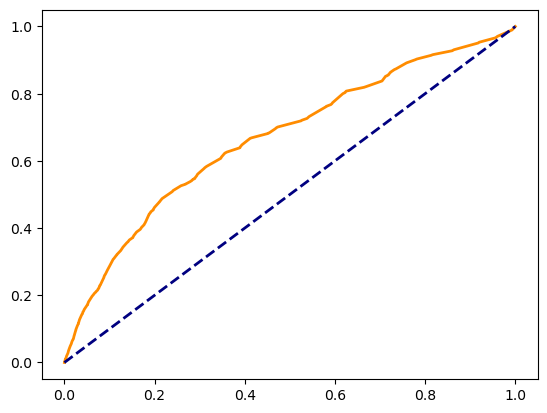

0.6670217672697658


In [16]:
calcAUC(data)

### 9
Висновок:

Логістична регресія:
Логістична регресія є потужним і широко використовуваним методом для розв'язання задач бінарної класифікації. Вона здатна моделювати ймовірності приналежності об'єктів до класів та враховувати взаємозв'язки між ознаками.

ROC (Receiver Operating Characteristic):
ROC-крива є ефективним інструментом для оцінки якості класифікатора, особливо у випадках збалансованих та знеуравноважених класів. Вона візуалізує торгові компроміси між чутливістю (вірні позитиви) та специфічністю (вірні негативи).

AUC (Area Under the Curve):
Площа під ROC-кривою (AUC) вимірює здатність класифікатора розділити позитивні та негативні екземпляри. Чим вищий AUC, тим краще виконується модель, ідеальний випадок - AUC = 1.

One-Hot Encoding:
One-Hot Encoding є ефективним методом для обробки категоріальних даних у вигляді бінарних змінних. Він дозволяє представити категорії у вигляді векторів з 0 і 1, полегшуючи роботу з алгоритмами машинного навчання, які вимагають числові дані.

У цьому дослідженні ми використали логістичну регресію для класифікації, оцінили її ефективність за допомогою ROC-кривої та AUC, і використовували One-Hot Encoding для обробки категоріальних даних. Ці методи допомагають покращити якість та ефективність моделей машинного навчання.

Виконав студент групи ІСТ-21-1, Дешков Максім Юрійович